In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


### 0) Dataset pre-process

In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

def rescale_dataset(scaled_size=(64,64), dataset_folder_path = 'images/original_img/', dataset_scaled_folder_path = 'images/scaled_img/'):
    data_fileList = os.listdir(dataset_folder_path)
    for data_file in data_fileList:
        in_img = Image.open(dataset_folder_path + data_file)
        # (x, y) = in_img.size
        out_img = in_img.resize(scaled_size, Image.ANTIALIAS)
        out_img.save(dataset_scaled_folder_path + data_file)

def dataset_to_RGB(dataset_scaled_folder_path = 'images/scaled_img/', dataset_text_path = 'images/anime.npy'):
    data_fileList = os.listdir(dataset_scaled_folder_path)
    dataset_text = []
    for data_file in data_fileList:
        # img = misc.imread(dataset_scaled_folder_path + data_file)
        img = Image.open(dataset_scaled_folder_path + data_file)
        x, y = img.size
        rgb = np.array(img.getdata()).reshape((x, y, -1))
        dataset_text.append(rgb)
    
    dataset_text = np.array(dataset_text)
    np.save(dataset_text_path, dataset_text)
    


### 1) Load dataset and define a plot function

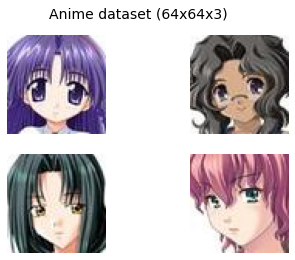

In [4]:
def load_real_samples(scale=False):
    # X = np.load('face_dataset_64x64.npy')[:20000, :, :, :]
    X = np.load('images/anime.npy')[:5000, :, :, :]
    # X = np.load('/content/drive/MyDrive/face_dataset_64x64.npy')[:20000, :, :, :]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False, change_process=False, filepath=None):
    if scale:
        images = (images + 1) / 2.0
    images_num = images.shape[0]

    if images_num < 4 or change_process:
        for index in range(images_num):
            plt.subplot(1, images_num, 1 + index)
            plt.axis('off')
            plt.imshow(images[index])
    else:
        for index in range(n * n):
            plt.subplot(n, n, 1 + index)
            plt.axis('off')
            plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        if change_process:
            filename = filepath + str(images_num)
            plt.savefig(filename)
            plt.close()
        else:
            filename = 'images_generated/generated_plot_e%03d_f.png' % (epoch+1) if filepath is None else filepath
            print(filename)
            plt.savefig(filename)
            plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 4)], name='Anime dataset (64x64x3)', n=2)

### 2) Define (de)convolutional networks for both VAE and GAN

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, filters=128, **default_args))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=128))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    # model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network, however the Conv2DTranspose layers are used instead. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    input. 
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(Reshape((4, 4, 64)))
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=128))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    # model.summary()
    return model

### 3) Build VAE and train using reparameter trick
##### 3.1) Build VAE

In [6]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim):

  
    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid')
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae


##### 3.2) Train VAE

In [7]:
# Training the VAE model

latent_dim = 64
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim)

In [25]:
# Generate random vectors that we will use to sample our latent space
np.random.seed(1024)
latent_vectors = np.random.randn(9, latent_dim)
vae_model_path = 'model/40_epoch_3in1_vae_1/vae_model_40epochs'
decoder_model_path = 'model/40_epoch_3in1_vae_1/decoder_model_40epochs'
encoder_model_path = 'model/40_epoch_3in1_vae_1/encoder_model_40epochs'
def train_vae(save=False):
    for epoch in range(40):
        vae.fit(dataset, dataset, epochs=1, batch_size=4)
        images = decoder(latent_vectors)
        grid_plot(images, epoch, name='VAE generated images', n=3, save=True)
    if save:
        vae.save(vae_model_path)
        decoder.save(decoder_model_path)
        encoder.save(encoder_model_path)

train_vae(save=True)

1250/1250 [==============================] - 14s 11ms/step - loss: 0.6085
images_generated/generated_plot_e001_f.png
1250/1250 [==============================] - 13s 11ms/step - loss: 0.5849
images_generated/generated_plot_e002_f.png
1250/1250 [==============================] - 13s 11ms/step - loss: 0.5790
images_generated/generated_plot_e003_f.png
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5757
images_generated/generated_plot_e004_f.png
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5733
images_generated/generated_plot_e005_f.png
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5718
images_generated/generated_plot_e006_f.png
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5709
images_generated/generated_plot_e007_f.png
1250/1250 [==============================] - 14s 11ms/step - loss: 0.5696
images_generated/generated_plot_e008_f.png
1250/1250 [==============================] - 14s 11ms/step - los

### 4) Build GAN and train
##### 4.1) Build GAN

In [8]:
def build_gan(data_shape, latent_dim, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh')
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN


##### 4.2) Train GAN

In [9]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y

def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64, save=False):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)
        if (epoch + 1) % 20 == 0:
            # np.random.seed(451)
            noise = np.random.randn(16, latent_dim)
            images = generator.predict(noise)
            grid_plot(images, epoch, name='GAN generated images', n=3, save=True, scale=True)
            print('photo saved')
        # save model
        if (epoch + 1) % 200 == 0 and save:
            gan_path = 'model/gan_model_epoch' + str(epoch)
            generator_path = 'model/generator_model_epoch' + str(epoch)
            discriminator_path = 'model/discriminator_model_epoch' + str(epoch)
            # print('model weight saved to:' + path)
            gan.save(gan_path)
            generator.save(generator_path)
            discriminator.save(discriminator_path)


In [13]:
# Build the model
latent_dim = 128
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim)
dataset_scaled = load_real_samples(scale=True)
print(dataset.shape)


(5000, 64, 64, 3)


In [ ]:
# Train the model (need around 10 epochs to start seeing some results)
train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=400)

##### 4.3) Develop an interpolation function and generates something interesting based on GAN

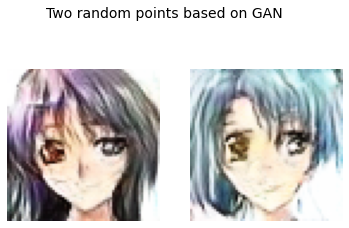

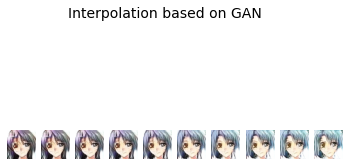

In [14]:
# Your code
latent_dim = 128
def linear_interpolation(vector1, vector2, interpolation_nums):
    ratio_lst = np.linspace(0, 1, interpolation_nums)
    interpolation_vectors = []
    for ratio in ratio_lst:
        vector = (1.0 - ratio) * vector1 + ratio * vector2
        interpolation_vectors.append(vector)
    interpolation_vectors = np.array(interpolation_vectors)
    return interpolation_vectors

# load generator model
generator = load_model('model/400_epoch_3in1_gan/generator_model_epoch399')
# generate 2 random points in the latent space
np.random.seed(44)
random_vecs = np.random.randn(2, latent_dim)
# get vectors interpolated
interpolation_vectors = linear_interpolation(random_vecs[0], random_vecs[1], 10)
# plot 2 random vecs and 10 interpolated vecs
random_images = generator.predict(random_vecs)
interpolation_images = generator.predict(interpolation_vectors)
grid_plot(random_images, name='Two random points based on GAN', n=2, save=False, scale=True, change_process=True, filepath='images_generated/interpolation') # 2 random vecs
grid_plot(interpolation_images, name='Interpolation based on GAN', n=3, save=False, scale=True, change_process=True, filepath='images_generated/interpolation') # 10 interpolated vecs


##### 4.4) Try for addition and substraction based on GAN

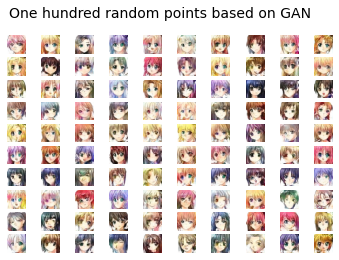

In [16]:
np.random.seed(334)
latent_dim = 128
random_vecs = np.random.randn(100, latent_dim)
random_images = generator.predict(random_vecs)
grid_plot(random_images, name='One hundred random points based on GAN', n=10, save=False, scale=True, filepath='images_generated/gan_random100.png') # 100 random vecs

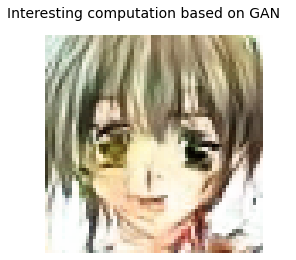

In [18]:
# index from 0, locate the exact position of a image in the images matrix.
female_mouth_opened_idx = [6, 21, 81]
female_mouth_closed_idx = [2, 88, 23]
male_mouth_closed_idx = [0, 78, 43]

# average vectors sharing the same feature.
def average_vectors(vecs, index):
    vectors_filtered = vecs[index]
    return np.mean(vectors_filtered, axis=0)

female_mouth_opened_avg_vecs = average_vectors(random_vecs, female_mouth_opened_idx)
female_mouth_closed_avg_vecs = average_vectors(random_vecs, female_mouth_closed_idx)
male_mouth_closed_avg_vecs = average_vectors(random_vecs, male_mouth_closed_idx)

male_mouth_opened_vecs = female_mouth_opened_avg_vecs - female_mouth_closed_avg_vecs + male_mouth_closed_avg_vecs
male_mouth_opened_vecs = np.expand_dims(male_mouth_opened_vecs, 0)
male_mouth_opened_images = generator.predict(male_mouth_opened_vecs)
grid_plot(male_mouth_opened_images, name='Interesting computation based on GAN', n=10, save=False, scale=True, filepath='images_generated/gan_fun.png') # 100 random vecs

##### 3.3) Develop an interpolation function and generates something interesting based on VAE

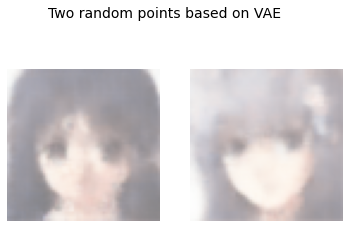

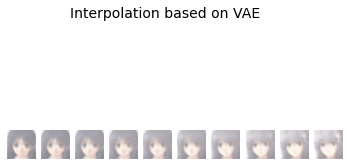

In [32]:
# load generator model
latent_dim = 64
decoder = load_model('model/40_epoch_3in1_vae/others/decoder_model_40epochs')
# generate 2 random points in the latent space
np.random.seed(999)
random_vecs = np.random.randn(2, latent_dim)
# get vectors interpolated
interpolation_vectors = linear_interpolation(random_vecs[0], random_vecs[1], 10)
# plot 2 random vecs and 10 interpolated vecs
random_images = decoder.predict(random_vecs)
interpolation_images = decoder.predict(interpolation_vectors)
grid_plot(random_images, name='Two random points based on VAE', n=2, save=False, scale=True, change_process=True, filepath='images_generated/interpolation_vae_seed23') # 2 random vecs
grid_plot(interpolation_images, name='Interpolation based on VAE', n=3, save=False, scale=True, change_process=True, filepath='images_generated/interpolation_vae_seed23') # 10 interpolated vecs

##### 3.4) Try for addition and substraction based on VAE

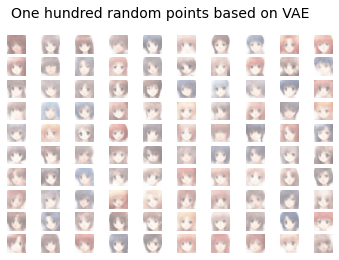

In [21]:
np.random.seed(334)
latent_dim = 64
np.random.seed(4)
random_vecs = np.random.randn(100, latent_dim)
random_images = decoder.predict(random_vecs)
grid_plot(random_images, name='One hundred random points based on VAE', n=10, save=False, scale=True, filepath='images_generated/vae_random100.png') # 100 random vecs

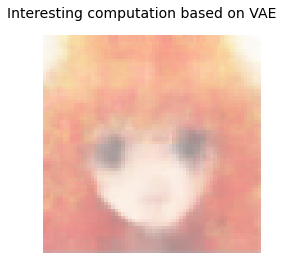

In [22]:
# index from 0, locate the exact position of a image in the images matrix.
short_red_hair_idx = [17, 43, 89]
short_blue_hair_idx = [56, 19, 28]
long_red_hair_idx = [0, 8, 96]
# latent_dim = 64
short_red_hair_3vectors = random_vecs[short_red_hair_idx]
short_blue_hair_3vectors = random_vecs[short_blue_hair_idx]
long_red_hair_3vectors = random_vecs[long_red_hair_idx]

short_red_hair_3images = decoder.predict(short_red_hair_3vectors)
short_blue_hair_3images = decoder.predict(short_blue_hair_3vectors)
long_red_hair_3images = decoder.predict(long_red_hair_3vectors)
grid_plot(short_red_hair_3images, name='Short red Hair based on VAE', n=10, save=False, scale=True, change_process=True) # 100 random vecs
grid_plot(short_blue_hair_3images, name='Short blue hair based on VAE', n=10, save=False, scale=True, change_process=True) # 100 random vecs
grid_plot(long_red_hair_3images, name='Long red hair based on VAE', n=10, save=False, scale=True, change_process=True) # 100 random vecs

# average vectors sharing the same feature.
def average_vectors(vecs, index):
    vectors_filtered = vecs[index]
    return np.mean(vectors_filtered, axis=0)

short_red_hair_vecs = average_vectors(random_vecs, short_red_hair_idx)
short_blue_hair_vecs = average_vectors(random_vecs, short_blue_hair_idx)
long_red_hair_vecs = average_vectors(random_vecs, long_red_hair_idx)

long_red_vecs = short_red_hair_vecs - short_blue_hair_vecs + long_red_hair_vecs
long_red_vecs = np.expand_dims(long_red_vecs, 0)
long_red_images = decoder.predict(long_red_vecs)
grid_plot(long_red_images, name='Interesting computation based on VAE', n=10, save=False, scale=True, filepath='images_generated/vae_fun.png') # 100 random vecs